# Deep Learning with Python
## Example 4.1 (Repeat) - Regularization Methods

### Importing Libraries and Dataset

In [1]:
import tensorflow, keras

# necessary to read dataset from pickle file - Numpy compatibility issues
import numpy as np
old = np.load
np.load = lambda *a,**k: old(*a, allow_pickle=True, **k)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Read the dataset
from keras.datasets import imdb

# Extract samples and labels
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000) # 10k most commonly occurring words only

### Creating Original Model

In [8]:
# Try newer version of numpy
import numpy as np

# Vectorization - converting each review to tensor of floats 
# Each sample is a sparse One-Hot encoded tensor of dim 10k that is 1 only when the word index matches column index
def vectorize_sequences(sequences, dimension=10000):
    # Matrix with one row per message and one column per possible word
    results = np.zeros((len(sequences), dimension))
    
    # For every word in the sequence of integers representing a review
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.    # set the column to 1 if word index = column index (NOT INTEGER)
        
    # Return one-hot encoded sample matrix
    return results

In [9]:
# Encode training and test samples
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [10]:
# Convert the labels to floating numpy arrays
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [14]:
# Creating model
from keras import models, layers

# Defining a function to create a Sequential, densely connected model with specific nodes
def create_model_with_n_nodes(n_nodes=16):
    # Instantiate
    model = models.Sequential()

    # Add layers with specified number of nodes per layer
    model.add(layers.Dense(n_nodes, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(n_nodes, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile model with required optimizer and loss
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Return the model
    return model

In [24]:
# Creating partial training and validation data
x_val = x_train[:10000]
y_val = y_train[:10000]
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

In [25]:
# Defining a function that will train model using partial training and test data 
# Not good programming practice because global variables but I'm just testing
def train_model(my_model, verbose_flag=0):
    my_model_history = my_model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, 
                                    verbose=verbose_flag, validation_data=(x_val, y_val))
    return my_model_history

In [26]:
# Training Original Model
org_model = create_model_with_n_nodes(n_nodes=16)
org_model_hist = train_model(org_model, verbose_flag=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 166us/step - loss: 0.5224 - acc: 0.7745 - val_loss: 0.3962 - val_acc: 0.8602
Epoch 2/20
15000/15000 [==============================] - 1s 97us/step - loss: 0.3146 - acc: 0.8999 - val_loss: 0.3118 - val_acc: 0.8842
Epoch 3/20
15000/15000 [==============================] - 1s 93us/step - loss: 0.2305 - acc: 0.9254 - val_loss: 0.3006 - val_acc: 0.8801
Epoch 4/20
15000/15000 [==============================] - 1s 94us/step - loss: 0.1815 - acc: 0.9435 - val_loss: 0.2788 - val_acc: 0.8879
Epoch 5/20
15000/15000 [==============================] - 1s 94us/step - loss: 0.1481 - acc: 0.9545 - val_loss: 0.2776 - val_acc: 0.8873
Epoch 6/20
15000/15000 [==============================] - 2s 132us/step - loss: 0.1215 - acc: 0.9634 - val_loss: 0.3098 - val_acc: 0.8792
Epoch 7/20
15000/15000 [==============================] - 2s 120us/step - loss: 0.0998 - acc: 0.9721 - val_loss: 0.3023 - val_

### Training Model with 4 Nodes per Layer

In [45]:
# Instantiate
model_4_nodes = create_model_with_n_nodes(n_nodes=4)

# Train
model_4_nodes_hist = train_model(model_4_nodes, verbose_flag=0)

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

# Defining a function make plot of validation losses using two model hist objects
def plot_validation_loss(model_1_history, model_2_history, title_str, model_2_str):
    plt.figure(figsize=(6,4))
    epochs = range(1, len(model_2_history.history['val_loss']) + 1)
    plt.plot(epochs, model_1_history.history['val_loss'], 'b+', label='Original Model')
    plt.plot(epochs, model_2_history.history['val_loss'], 'ro', label=str(model_2_str))
    plt.legend(); plt.grid(True); plt.xlabel('Epochs'); plt.ylabel('Validation Loss')
    plt.title(title_str); plt.tight_layout(); plt.show();

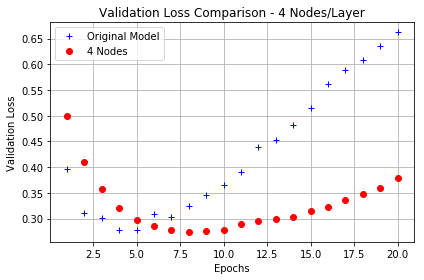

In [47]:
# Plotting validation set losses for original model and 4 node model
plot_validation_loss(org_model_hist, model_4_nodes_hist, title_str='Validation Loss Comparison - 4 Nodes/Layer',
                     model_2_str='4 Nodes')

### Interpretation
- My model's validation loss trends finally match those of the book
- I think the previous error could have been caused by
    - Old `numpy` version. This time I imported a new numpy version in the vectorization sequence function.
    - Different `random_state`s at some point in the workflow.
    - Changing the loss flags from integer `(1)` to `float32` `1.` in the `vectorize_sequences` function.
- It's stil not the exact same trend as the book for the 4 node model, but it's close enough.

### Training Model with 512 Nodes per Layer - Serious Overfitting

In [48]:
model_512_nodes = create_model_with_n_nodes(n_nodes=512)
model_512_hist = train_model(model_512_nodes, verbose_flag=0)

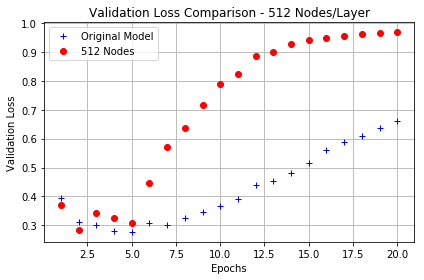

In [50]:
plot_validation_loss(org_model_hist, model_512_hist, title_str='Validation Loss Comparison - 512 Nodes/Layer', 
                    model_2_str='512 Nodes')

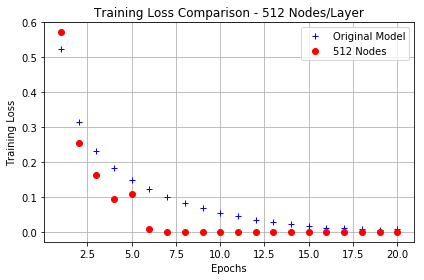

In [55]:
plt.figure(figsize=(6,4))
epochs = range(1, len(model_512_hist.history['loss']) + 1)
plt.plot(epochs, org_model_hist.history['loss'], 'b+', label='Original Model')
plt.plot(epochs, model_512_hist.history['loss'], 'ro', label=str('512 Nodes'))
plt.legend(); plt.grid(True); plt.xlabel('Epochs'); plt.ylabel('Training Loss')
plt.title('Training Loss Comparison - 512 Nodes/Layer'); plt.tight_layout(); plt.show();

### Interpretation
- 512 nodes for layers drastically increases the memorization capacity of the neural network - far more than is required for the given problem.
- Thus, the 512 node/layer model is more susceptible to overfitting than the original model.
- Evidence for this can be seen in the graphs comparing the model's validation loss and training loss with those of the original model.
- The 512 node/layer model starts overfitting almost instantly (after 2 epochs), as its validation set loss increases and continues to be larger than that of the original model for all subsequent epochs.
- Similarly, because it is so quick to overfit, its training set loss become susbstantially lower than the original model's after only 2 epochs, and becomes virtually zero from epoch 6 onwards. 
- As the original model has fewer nodes per layers and thus lower memorization capacity, it doesn't start overfitting until much later in the training process (epochs 6 - 7), and even then its validation loss increases more slowly than that of the 512 node model.